# Data Profile Comparison: Clean vs Non-IID Hard

This notebook compares the two data generation profiles:
- **`clean`**: Existing behavior (IID-ish, uniform partitioning)
- **`non_iid_hard`**: Strongly heterogeneous data for stress-testing FL

The `non_iid_hard` profile implements 4 dimensions of heterogeneity:
1. **Label Skew**: Each client sees a different RUL distribution
2. **Feature Skew**: Client-specific sensor bias and noise
3. **Quantity Skew**: Imbalanced dataset sizes per client
4. **Concept Drift**: Temporal drift for long experiments

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Imports successful!")

Imports successful!


## 1. Generate Data with Both Profiles

In [2]:
from experiments.federated_matrix import create_synthetic_data, partition_data_for_clients
from src.data.non_iid_generator import (
    generate_non_iid_hard_data,
    get_data_profile_stats,
    CLIENT_NOISE,
    CLIENT_BIAS,
    CLIENT_DATA_SIZES,
)

# Configuration
NUM_CLIENTS = 5
SEQ_LENGTH = 100
NUM_CHANNELS = 14
SEED = 42

print("="*60)
print("NON-IID HARD PROFILE CONFIGURATION")
print("="*60)
print(f"\nClient Noise Levels: {CLIENT_NOISE}")
print(f"Client Bias Levels: {CLIENT_BIAS}")
print(f"Client Data Sizes: {CLIENT_DATA_SIZES}")

NON-IID HARD PROFILE CONFIGURATION

Client Noise Levels: {0: 0.1, 1: 0.5, 2: 0.2, 3: 1.0, 4: 0.05}
Client Bias Levels: {0: 0.0, 1: 2.0, 2: -2.0, 3: 5.0, 4: 0.0}
Client Data Sizes: {0: 800, 1: 200, 2: 150, 3: 50, 4: 300}


In [3]:
# Generate CLEAN profile data
print("\n" + "="*60)
print("CLEAN PROFILE")
print("="*60)

X_clean, y_clean = create_synthetic_data(
    num_samples=1500,
    seq_length=SEQ_LENGTH,
    num_channels=NUM_CHANNELS,
    task="rul",
    seed=SEED,
)

clean_partitions = partition_data_for_clients(
    X_clean, y_clean,
    num_clients=NUM_CLIENTS,
    heterogeneity_mode="uniform",
    seed=SEED,
)

print(f"Total samples: {len(X_clean)}")
for i, (X_c, y_c) in enumerate(clean_partitions):
    print(f"  Client {i}: {len(X_c)} samples, RUL: [{y_c.min():.1f}, {y_c.max():.1f}], mean: {y_c.mean():.1f}")


CLEAN PROFILE
Total samples: 1500
  Client 0: 300 samples, RUL: [63.0, 94.5], mean: 81.0
  Client 1: 300 samples, RUL: [61.6, 94.8], mean: 81.0
  Client 2: 300 samples, RUL: [61.1, 94.6], mean: 81.3
  Client 3: 300 samples, RUL: [63.5, 94.4], mean: 81.2
  Client 4: 300 samples, RUL: [63.6, 94.8], mean: 79.9


In [4]:
# Generate NON-IID HARD profile data
print("\n" + "="*60)
print("NON-IID HARD PROFILE")
print("="*60)

hard_partitions = generate_non_iid_hard_data(
    num_clients=NUM_CLIENTS,
    seq_length=SEQ_LENGTH,
    num_channels=NUM_CHANNELS,
    task="rul",
    seed=SEED,
)

total_samples = sum(len(X_c) for X_c, _ in hard_partitions)
print(f"Total samples: {total_samples}")
for i, (X_c, y_c) in enumerate(hard_partitions):
    print(f"  Client {i}: {len(X_c)} samples, RUL: [{y_c.min():.1f}, {y_c.max():.1f}], mean: {y_c.mean():.1f}")

# Show detailed stats
stats = get_data_profile_stats(hard_partitions)
print("\nDetailed Statistics:")
for client, s in stats.items():
    print(f"  {client}: X_mean={s['X_mean']:.2f}, X_std={s['X_std']:.2f}, bias={s['feature_bias']}, noise={s['feature_noise']}")


NON-IID HARD PROFILE
Total samples: 1500
  Client 0: 800 samples, RUL: [0.0, 29.9], mean: 15.0
  Client 1: 200 samples, RUL: [30.1, 60.0], mean: 45.6
  Client 2: 150 samples, RUL: [60.0, 100.0], mean: 82.6
  Client 3: 50 samples, RUL: [1.8, 99.2], mean: 50.9
  Client 4: 300 samples, RUL: [0.3, 99.8], mean: 48.3

Detailed Statistics:
  client_0: X_mean=0.22, X_std=0.79, bias=0.0, noise=0.1
  client_1: X_mean=2.23, X_std=0.94, bias=2.0, noise=0.5
  client_2: X_mean=-1.77, X_std=0.82, bias=-2.0, noise=0.2
  client_3: X_mean=5.22, X_std=1.28, bias=5.0, noise=1.0
  client_4: X_mean=0.23, X_std=0.79, bias=0.0, noise=0.05


## 2. Visualize Label Skew (RUL Distribution)

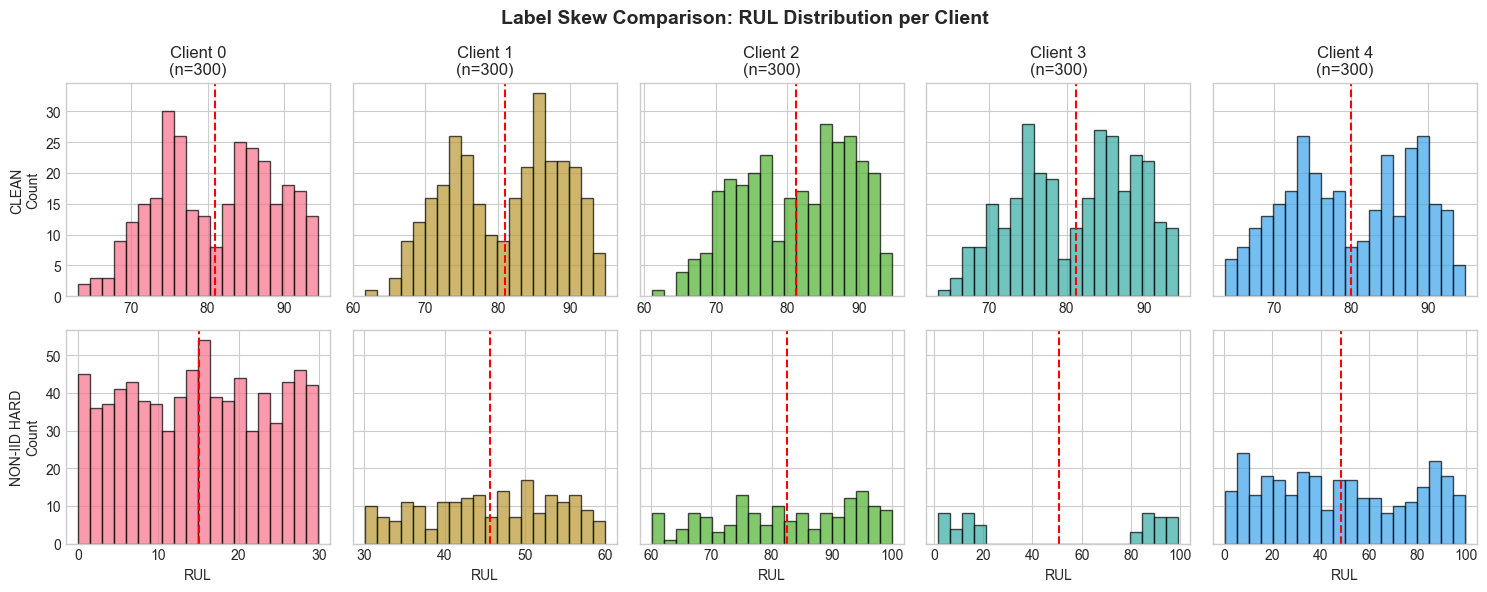

In [5]:
fig, axes = plt.subplots(2, NUM_CLIENTS, figsize=(15, 6), sharey='row')

# Clean profile
for i, (X_c, y_c) in enumerate(clean_partitions):
    axes[0, i].hist(y_c, bins=20, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[0, i].set_title(f'Client {i}\n(n={len(y_c)})')
    axes[0, i].axvline(y_c.mean(), color='red', linestyle='--', label=f'mean={y_c.mean():.1f}')
    if i == 0:
        axes[0, i].set_ylabel('CLEAN\nCount')

# Non-IID Hard profile
for i, (X_c, y_c) in enumerate(hard_partitions):
    axes[1, i].hist(y_c, bins=20, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[1, i].set_xlabel('RUL')
    axes[1, i].axvline(y_c.mean(), color='red', linestyle='--', label=f'mean={y_c.mean():.1f}')
    if i == 0:
        axes[1, i].set_ylabel('NON-IID HARD\nCount')

fig.suptitle('Label Skew Comparison: RUL Distribution per Client', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Visualize Quantity Skew (Data Imbalance)

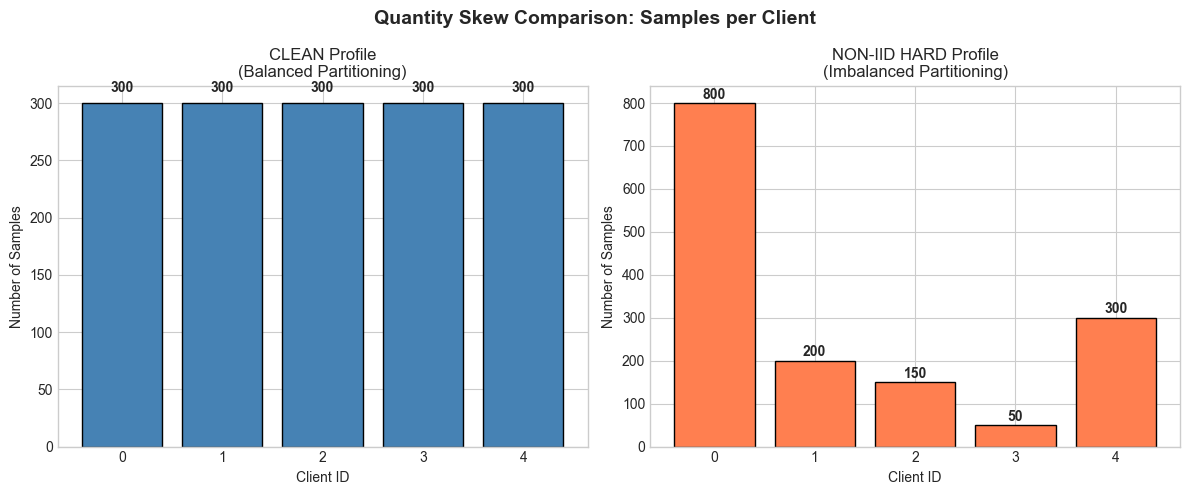


Clean profile - Max/Min ratio: 1.00
Non-IID Hard profile - Max/Min ratio: 16.00


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Clean profile sample counts
clean_counts = [len(X_c) for X_c, _ in clean_partitions]
axes[0].bar(range(NUM_CLIENTS), clean_counts, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Client ID')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('CLEAN Profile\n(Balanced Partitioning)')
axes[0].set_xticks(range(NUM_CLIENTS))
for i, c in enumerate(clean_counts):
    axes[0].text(i, c + 10, str(c), ha='center', fontweight='bold')

# Non-IID Hard profile sample counts
hard_counts = [len(X_c) for X_c, _ in hard_partitions]
axes[1].bar(range(NUM_CLIENTS), hard_counts, color='coral', edgecolor='black')
axes[1].set_xlabel('Client ID')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('NON-IID HARD Profile\n(Imbalanced Partitioning)')
axes[1].set_xticks(range(NUM_CLIENTS))
for i, c in enumerate(hard_counts):
    axes[1].text(i, c + 10, str(c), ha='center', fontweight='bold')

fig.suptitle('Quantity Skew Comparison: Samples per Client', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print imbalance metrics
print(f"\nClean profile - Max/Min ratio: {max(clean_counts)/min(clean_counts):.2f}")
print(f"Non-IID Hard profile - Max/Min ratio: {max(hard_counts)/min(hard_counts):.2f}")

## 4. Visualize Feature Skew (Sensor Behavior)

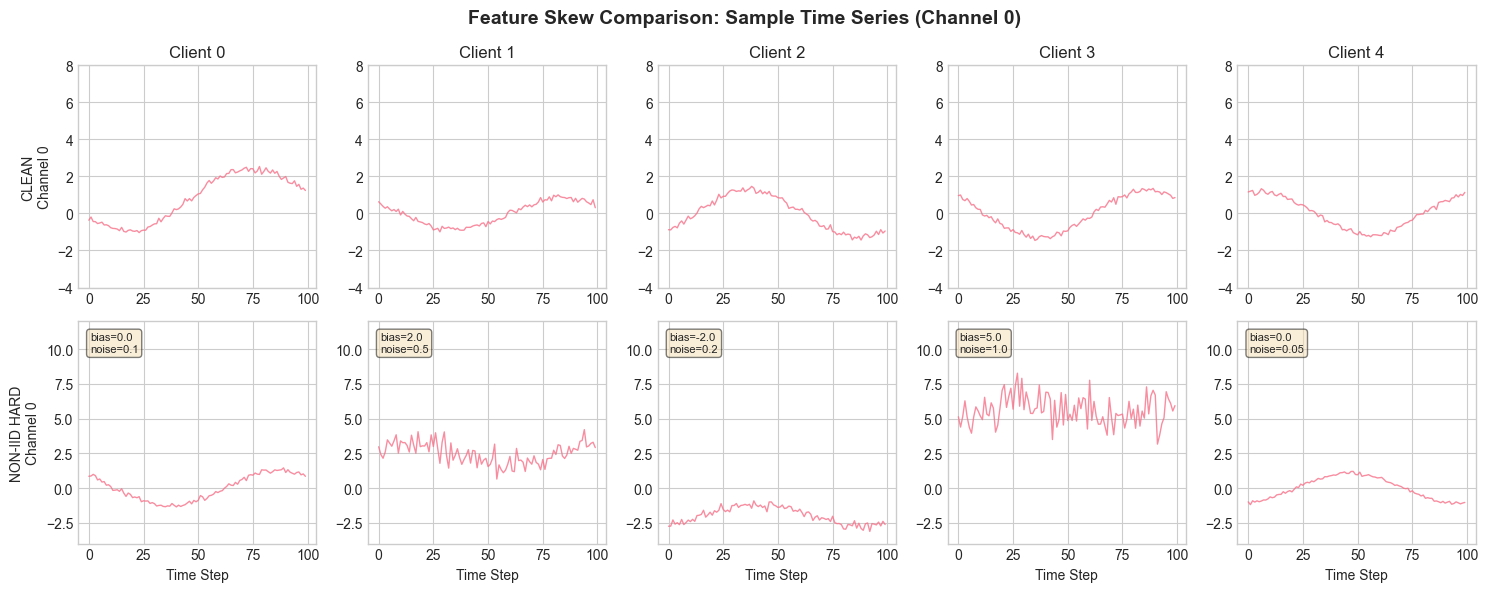

In [7]:
fig, axes = plt.subplots(2, NUM_CLIENTS, figsize=(15, 6))

channel_to_show = 0  # Show first channel

# Clean profile - sample time series
for i, (X_c, y_c) in enumerate(clean_partitions):
    sample_idx = 0
    axes[0, i].plot(X_c[sample_idx, :, channel_to_show], alpha=0.8, linewidth=1)
    axes[0, i].set_title(f'Client {i}')
    if i == 0:
        axes[0, i].set_ylabel('CLEAN\nChannel 0')
    axes[0, i].set_ylim(-4, 8)

# Non-IID Hard profile - sample time series
for i, (X_c, y_c) in enumerate(hard_partitions):
    sample_idx = 0
    axes[1, i].plot(X_c[sample_idx, :, channel_to_show], alpha=0.8, linewidth=1)
    axes[1, i].set_xlabel('Time Step')
    if i == 0:
        axes[1, i].set_ylabel('NON-IID HARD\nChannel 0')
    # Annotate with bias/noise
    bias = CLIENT_BIAS.get(i, 0.0)
    noise = CLIENT_NOISE.get(i, 0.15)
    axes[1, i].text(0.05, 0.95, f'bias={bias}\nnoise={noise}', 
                    transform=axes[1, i].transAxes, fontsize=8, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, i].set_ylim(-4, 12)

fig.suptitle('Feature Skew Comparison: Sample Time Series (Channel 0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

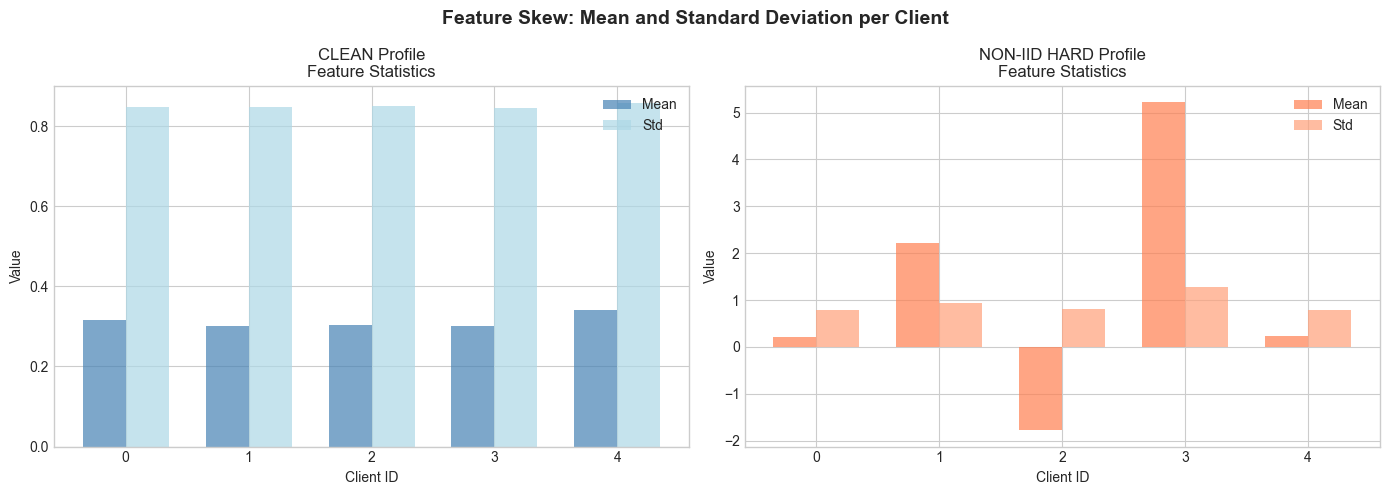

In [8]:
# Show feature distribution statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clean profile feature distribution
clean_means = [X_c.mean() for X_c, _ in clean_partitions]
clean_stds = [X_c.std() for X_c, _ in clean_partitions]

x = np.arange(NUM_CLIENTS)
width = 0.35
axes[0].bar(x - width/2, clean_means, width, label='Mean', color='steelblue', alpha=0.7)
axes[0].bar(x + width/2, clean_stds, width, label='Std', color='lightblue', alpha=0.7)
axes[0].set_xlabel('Client ID')
axes[0].set_ylabel('Value')
axes[0].set_title('CLEAN Profile\nFeature Statistics')
axes[0].set_xticks(x)
axes[0].legend()

# Non-IID Hard profile feature distribution
hard_means = [X_c.mean() for X_c, _ in hard_partitions]
hard_stds = [X_c.std() for X_c, _ in hard_partitions]

axes[1].bar(x - width/2, hard_means, width, label='Mean', color='coral', alpha=0.7)
axes[1].bar(x + width/2, hard_stds, width, label='Std', color='lightsalmon', alpha=0.7)
axes[1].set_xlabel('Client ID')
axes[1].set_ylabel('Value')
axes[1].set_title('NON-IID HARD Profile\nFeature Statistics')
axes[1].set_xticks(x)
axes[1].legend()

fig.suptitle('Feature Skew: Mean and Standard Deviation per Client', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Summary Statistics Comparison

In [10]:
import pandas as pd

# Build comparison table
rows = []

for i in range(NUM_CLIENTS):
    X_clean_c, y_clean_c = clean_partitions[i]
    X_hard_c, y_hard_c = hard_partitions[i]
    
    rows.append({
        'Client': i,
        'Profile': 'clean',
        'N_Samples': len(X_clean_c),
        'RUL_Mean': y_clean_c.mean(),
        'RUL_Std': y_clean_c.std(),
        'RUL_Min': y_clean_c.min(),
        'RUL_Max': y_clean_c.max(),
        'X_Mean': X_clean_c.mean(),
        'X_Std': X_clean_c.std(),
    })
    rows.append({
        'Client': i,
        'Profile': 'non_iid_hard',
        'N_Samples': len(X_hard_c),
        'RUL_Mean': y_hard_c.mean(),
        'RUL_Std': y_hard_c.std(),
        'RUL_Min': y_hard_c.min(),
        'RUL_Max': y_hard_c.max(),
        'X_Mean': X_hard_c.mean(),
        'X_Std': X_hard_c.std(),
    })

df = pd.DataFrame(rows)
print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
display(df.round(2))


COMPARISON TABLE


,Client,Profile,N_Samples,RUL_Mean,RUL_Std,RUL_Min,RUL_Max,X_Mean,X_Std
0,0,clean,300,81.029999,7.610000,63.029999,94.489998,0.32,0.85
1,0,non_iid_hard,800,15.010000,8.660000,0.030000,29.870001,0.22,0.79
2,1,clean,300,81.010002,7.680000,61.639999,94.769997,0.30,0.85
3,1,non_iid_hard,200,45.630001,8.260000,30.080000,59.980000,2.23,0.94
4,2,clean,300,81.260002,7.650000,61.049999,94.610001,0.30,0.85
5,2,non_iid_hard,150,82.580002,11.360000,60.029999,99.980003,-1.77,0.82
6,3,clean,300,81.220001,7.490000,63.529999,94.360001,0.30,0.85
7,3,non_iid_hard,50,50.860001,40.139999,1.790000,99.190002,5.22,1.28
8,4,clean,300,79.940002,8.180000,63.610001,94.769997,0.34,0.86
9,4,non_iid_hard,300,48.259998,29.820000,0.340000,99.790001,0.23,0.79


In [11]:
# Compute heterogeneity metrics
def compute_heterogeneity_metrics(partitions, profile_name):
    n_samples = [len(X_c) for X_c, _ in partitions]
    y_means = [y_c.mean() for _, y_c in partitions]
    x_means = [X_c.mean() for X_c, _ in partitions]
    x_stds = [X_c.std() for X_c, _ in partitions]
    
    return {
        'Profile': profile_name,
        'Sample Imbalance (max/min)': max(n_samples) / min(n_samples),
        'RUL Mean Variance': np.var(y_means),
        'Feature Mean Variance': np.var(x_means),
        'Feature Std Variance': np.var(x_stds),
    }

metrics_clean = compute_heterogeneity_metrics(clean_partitions, 'clean')
metrics_hard = compute_heterogeneity_metrics(hard_partitions, 'non_iid_hard')

metrics_df = pd.DataFrame([metrics_clean, metrics_hard])
print("\n" + "="*80)
print("HETEROGENEITY METRICS")
print("(Higher values = more heterogeneous)")
print("="*80)
display(metrics_df.round(4))


HETEROGENEITY METRICS
(Higher values = more heterogeneous)


,Profile,Sample Imbalance (max/min),RUL Mean Variance,Feature Mean Variance,Feature Std Variance
0,clean,1.0,0.235800,0.0002,0.0000
1,non_iid_hard,16.0,459.397308,5.5938,0.0342


## 6. Expected Experimental Behavior

| Setting | Expected Outcome |
|---------|------------------|
| Clean + FL | Federated ≈ Centralized |
| Hard + FL | Federated < Centralized but >> Local-only |
| Hard + Local-only | Very poor performance |
| Hard + Centralized | Upper bound |

The `non_iid_hard` profile is designed to:
- Make results **harder**, not better
- Increase **noisiness** and **instability**
- Slow down **convergence**
- Test **robustness**, **fairness**, and **non-IID resilience**

In [12]:
print("\n" + "="*60)
print("USAGE INSTRUCTIONS")
print("="*60)
print("""
To use the data profiles in experiments:

1. In YAML config:
   data_profile: "clean"        # Default IID behavior
   data_profile: "non_iid_hard" # Heterogeneous stress test

2. From command line (federated_matrix.py):
   python -m experiments.federated_matrix --data-profile clean
   python -m experiments.federated_matrix --data-profile non_iid_hard

3. In Python:
   config = FederatedExperimentConfig(data_profile="non_iid_hard")
   experiment = FederatedExperiment(config)
   results = experiment.run()

NOTE: Changing data_profile ONLY affects data generation.
Training loops, model architecture, aggregation, metrics,
logging, and random seed handling remain UNCHANGED.
""")


USAGE INSTRUCTIONS

To use the data profiles in experiments:

1. In YAML config:
   data_profile: "clean"        # Default IID behavior
   data_profile: "non_iid_hard" # Heterogeneous stress test

2. From command line (federated_matrix.py):
   python -m experiments.federated_matrix --data-profile clean
   python -m experiments.federated_matrix --data-profile non_iid_hard

3. In Python:
   config = FederatedExperimentConfig(data_profile="non_iid_hard")
   experiment = FederatedExperiment(config)
   results = experiment.run()

NOTE: Changing data_profile ONLY affects data generation.
Training loops, model architecture, aggregation, metrics,
logging, and random seed handling remain UNCHANGED.

